In [1]:
import os
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
from seisbench.util import worker_seeding

import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obspy.clients.fdsn import Client
from obspy import UTCDateTime

### Modificacion de archivo de metadatos

In [2]:
#files location: /home/jbg/.seisbench/datasets/
metadatos = pd.read_csv("resultado_sismos2.csv")
metadatos.head()

,trace_coda_end_sample,source_depth_km,source_latitude_deg,source_longitude_deg,source_magnitude,source_origin_time,trace_p_arrival_sample,trace_p_arrival_time,trace_p_arrival_uncertainty_s,trace_s_arrival_sample,...,station_latitude_deg,station_longitude_deg,station_code,trace_category,trace_name_original,split,trace_name,trace_causal,trace_polarity,ID_poligono
0,1530.0,5.643115,31.244769,-103.553538,1.413654,2019-04-02T03:34:48.725819Z,1034.0,2019-04-02T03:34:52.621560Z,0.2,1282.0,...,31.408922,-103.510147,PCOS,earthquake_local,texnet2019gknw_PCOS_EV,train,"bucket268$338,:3,:6000",unknown,unknown,3
1,646.0,3.072314,31.445149,-103.586818,1.343138,2019-04-02T15:44:47.758892Z,398.0,2019-04-02T15:44:49.774274Z,0.2,522.0,...,31.408922,-103.510147,PCOS,earthquake_local,texnet2019glly_PCOS_EV,train,"bucket268$343,:3,:6000",unknown,unknown,4
2,1357.0,6.157275,31.274182,-103.572833,1.532322,2019-04-03T00:19:32.460730Z,863.0,2019-04-03T00:19:35.861650Z,0.3,1110.0,...,31.408922,-103.510147,PCOS,earthquake_local,texnet2019gmcy_PCOS_EV,test,"bucket267$962,:3,:6000",unknown,unknown,3
3,1602.0,5.540283,31.253961,-103.559968,2.021868,2019-04-03T02:49:31.391207Z,962.0,2019-04-03T02:49:34.487029Z,0.3,1282.0,...,31.408922,-103.510147,PCOS,earthquake_local,texnet2019gmhw_PCOS_EV,train,"bucket268$388,:3,:6000",unknown,unknown,3
4,959.0,6.131567,31.250054,-103.556485,1.866408,2019-04-03T04:07:27.403390Z,427.0,2019-04-03T04:07:31.281541Z,0.2,693.0,...,31.408922,-103.510147,PCOS,earthquake_local,texnet2019gmkl_PCOS_EV,train,"bucket268$401,:3,:6000",unknown,unknown,3


metadatos["Source_zone"] = np.random.randint(1,8,size=len(metadatos))
metadatos.head()

In [3]:
#Solo correr una vez
#metadatos.to_csv("/home/jbg/.seisbench/datasets/dummydataset/metadata.csv",index=False)

### Descarga de datos

In [4]:
data = sbd.TXED() #Esta accion es recomendable hacerla en terminal pues tarda mucho
                                #cambiar a "full" una vez que este completo el codigo
#data = sbd.DummyDataset(sampling_rate=50)  #sampling_rate=100
data.preload_waveforms(pbar=True) #importante, pbar==progressbar
print(data)

2024-08-26 13:04:02,602 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.
2024-08-26 13:04:02,603 | seisbench | WARNING | Skipping preload, as cache is disabled.


TXED - 1046 traces


/opt/miniforge3/envs/seisbench/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/miniforge3/envs/seisbench/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


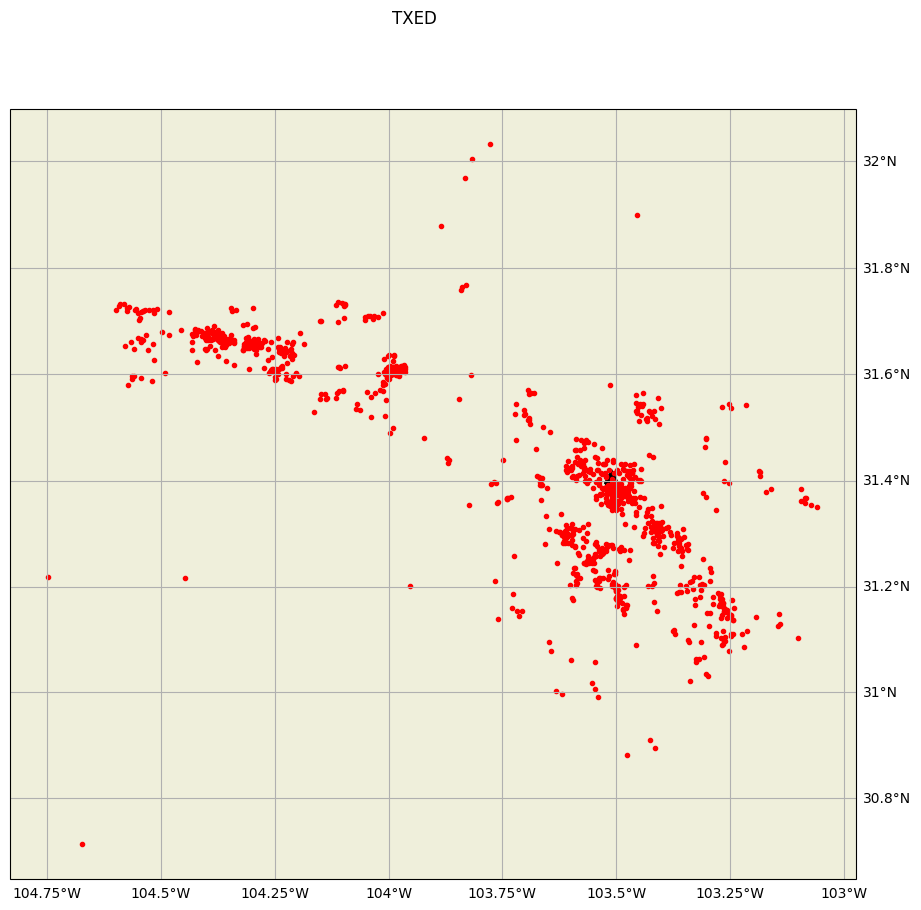

In [5]:
data.plot_map();

In [6]:
print("Cache root:", seisbench.cache_root)
print("Contents:", os.listdir(seisbench.cache_root))
print("datasets:", os.listdir(seisbench.cache_root / "datasets"))
print("dummydataset:", os.listdir(seisbench.cache_root / "datasets" / "txed"))

Cache root: /Users/roberto/.seisbench
Contents: ['config.json', 'datasets']
datasets: ['txed']
dummydataset: ['metadata.bak', 'waveforms.hdf5', 'metadata.csv', 'resultado_sismos2.csv']


### Metadatos

In [7]:
data.metadata.head(10)

,index,trace_coda_end_sample,source_depth_km,source_latitude_deg,source_longitude_deg,source_magnitude,source_origin_time,trace_p_arrival_sample,trace_p_arrival_time,trace_p_arrival_uncertainty_s,...,trace_category,trace_name_original,split,trace_name,trace_causal,trace_polarity,ID_poligono,trace_chunk,trace_sampling_rate_hz,trace_component_order
0,0,1530.0,5.643115,31.244769,-103.553538,1.413654,2019-04-02T03:34:48.725819Z,1034.0,2019-04-02T03:34:52.621560Z,0.2,...,earthquake_local,texnet2019gknw_PCOS_EV,train,"bucket268$338,:3,:6000",unknown,unknown,3,,100,ZNE
1,1,646.0,3.072314,31.445149,-103.586818,1.343138,2019-04-02T15:44:47.758892Z,398.0,2019-04-02T15:44:49.774274Z,0.2,...,earthquake_local,texnet2019glly_PCOS_EV,train,"bucket268$343,:3,:6000",unknown,unknown,4,,100,ZNE
2,2,1357.0,6.157275,31.274182,-103.572833,1.532322,2019-04-03T00:19:32.460730Z,863.0,2019-04-03T00:19:35.861650Z,0.3,...,earthquake_local,texnet2019gmcy_PCOS_EV,test,"bucket267$962,:3,:6000",unknown,unknown,3,,100,ZNE
3,3,1602.0,5.540283,31.253961,-103.559968,2.021868,2019-04-03T02:49:31.391207Z,962.0,2019-04-03T02:49:34.487029Z,0.3,...,earthquake_local,texnet2019gmhw_PCOS_EV,train,"bucket268$388,:3,:6000",unknown,unknown,3,,100,ZNE
4,4,959.0,6.131567,31.250054,-103.556485,1.866408,2019-04-03T04:07:27.403390Z,427.0,2019-04-03T04:07:31.281541Z,0.2,...,earthquake_local,texnet2019gmkl_PCOS_EV,train,"bucket268$401,:3,:6000",unknown,unknown,3,,100,ZNE
5,5,1021.0,5.643115,31.256718,-103.544963,1.864792,2019-04-03T04:49:40.161684Z,435.0,2019-04-03T04:49:43.337664Z,0.4,...,earthquake_local,texnet2019gmlv_PCOS_EV,train,"bucket268$412,:3,:6000",unknown,unknown,3,,100,ZNE
6,6,1405.0,5.745947,31.253961,-103.559968,1.405379,2019-04-03T05:06:24.699035Z,825.0,2019-04-03T05:06:28.181712Z,0.4,...,earthquake_local,texnet2019gmmk_PCOS_EV,train,"bucket268$418,:3,:6000",unknown,unknown,3,,100,ZNE
7,7,747.0,2.943774,31.406310,-103.521052,1.636805,2019-04-03T07:05:54.237476Z,611.0,2019-04-03T07:05:55.123389Z,0.1,...,earthquake_local,texnet2019gmqi_PCOS_EV,train,"bucket268$424,:3,:6000",unknown,D,4,,100,ZNE
8,8,960.0,5.797363,31.296690,-103.618409,2.109441,2019-04-03T21:30:03.889751Z,414.0,2019-04-03T21:30:07.163288Z,0.2,...,earthquake_local,texnet2019gnsv_PCOS_EV,test,"bucket267$998,:3,:6000",unknown,unknown,3,,100,ZNE
9,9,1147.0,5.360327,31.377796,-103.479209,1.944866,2019-04-04T17:08:35.427523Z,899.0,2019-04-04T17:08:36.990751Z,0.1,...,earthquake_local,texnet2019gpfs_PCOS_EV,train,"bucket268$484,:3,:6000",unknown,U,4,,100,ZNE


In [8]:
print(data.metadata.columns)
data.metadata["ID_poligono"]

Index(['index', 'trace_coda_end_sample', 'source_depth_km',
       'source_latitude_deg', 'source_longitude_deg', 'source_magnitude',
       'source_origin_time', 'trace_p_arrival_sample', 'trace_p_arrival_time',
       'trace_p_arrival_uncertainty_s', 'trace_s_arrival_sample',
       'trace_s_arrival_time', 'trace_s_arrival_uncertainty_s', 'trace_snr_db',
       'station_elevation_m', 'station_latitude_deg', 'station_longitude_deg',
       'station_code', 'trace_category', 'trace_name_original', 'split',
       'trace_name', 'trace_causal', 'trace_polarity', 'ID_poligono',
       'trace_chunk', 'trace_sampling_rate_hz', 'trace_component_order'],
      dtype='object')


0       3
1       4
2       3
3       3
4       3
       ..
1041    3
1042    3
1043    3
1044    2
1045    6
Name: ID_poligono, Length: 1046, dtype: int64

### Cargar el Modelo

In [9]:
model = sbm.ConvNQ(num_classes=8,input_length=6001)#Funciona a partir de num_classes=8
print(model)

SeisBench model		ConvNQ

ConvNQ(
  (conv_layers): Sequential(
    (0): Conv1d(3, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU()
    (6): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): ReLU()
    (8): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (9): ReLU()
    (10): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (11): ReLU()
    (12): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (13): ReLU()
    (14): Conv1d(32, 32, kernel_size=(3,), stride=(2,), padding=(1,))
    (15): ReLU()
  )
  (fc1): Linear(in_features=768, out_features=8, bias=True)
)


### Separar los datos

In [10]:
train, dev, test = data.train_dev_test()

### Generar Pipeline

Es necesario hace un generator por que asi es mas facil cargar los datos a la red, pues son pytorch datasets

In [11]:
train_generator = sbg.GenericGenerator(train)
test_generator = sbg.GenericGenerator(test)
dev_generator = sbg.GenericGenerator(dev)

In [12]:
print(type(dev_generator))
print(len(dev_generator))
print(dev_generator[0])

<class 'seisbench.generate.generator.GenericGenerator'>
123
{'X': array([[-384.13638944, -548.60011245, -612.88716667, ...,   44.29332608,
          41.00698049,   97.20349551],
       [ -15.91861406,   80.2284558 ,  160.3251092 , ..., -198.22024323,
        -262.96597583, -312.79675264],
       [ 249.6963852 ,  227.58526375,  208.80678419, ..., -417.83288355,
        -333.61868878, -182.10666925]])}


In [13]:
dev_generator[0].keys()

dict_keys(['X'])

In [14]:
dev_generator[0]['X'].shape

(3, 6000)

#### Augmentation

Con "augmentation" se puede agregar datos como picks para los traces o una clasificacion

In [15]:
#train_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
#test_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
#dev_generator.augmentation(sbg.Normalize(detrend_axis=-1, amp_norm_axis=-1))
@train_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)

@test_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)

@dev_generator.augmentation
def add_zone(state_dict):
    waveforms, metadata = state_dict["X"]
    state_dict["y"] = (metadata["ID_poligono"], None)

print(dev_generator[1])

{'X': array([[-2564.74671223, -2864.34034201, -2747.32305434, ...,
         1030.97250503,  1323.74649157,  1398.18321201],
       [  512.27768192,  -239.03769364,  -562.60586866, ...,
          243.0166712 ,   288.61627134,   119.01541623],
       [  892.26094363,  1440.91392095,  1487.25689782, ...,
          180.41883344,   199.33910987,   234.60733681]]), 'y': 6}


### Dataloaders

In [23]:
batch_size = 256
num_workers = 0  # The number of threads used for loading data

#worker_init_fn es principalmente usado cuando se trabaja en parallelo para que todos los "workers" tengan mismas condiciones 
train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=0)

###  Training

#### Prep

In [24]:
learning_rate = 1e-2
epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#print_every = 100
training_losses = []
training_accs = []
val_accuracy = []
val_losing = []


In [25]:
def train_loop(dataloader):
    size = len(dataloader.dataset)
    for batch_id, batch in enumerate(dataloader):
        # Compute prediction and loss
        pred = model.predict(batch["X"].to(model.device))
        loss = model.loss_function(torch.tensor(pred), batch["y"].to(model.device))
        

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        
        #Para imprimir valores
        if batch_id % 5 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    training_losses.append(loss.item())
    training_accs.append(model.accuracy(torch.tensor(pred), batch["y"].to(model.device)))
        


def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    model.eval()  # close the model for evaluation

    with torch.no_grad():
        for batch in dataloader:
            pred = model.predict(batch["X"].to(model.device))
            test_loss += model.loss_function(torch.tensor(pred), batch["y"].to(model.device)).item()

            
    model.train()  # re-open model for training stage

    test_loss /= num_batches
    print(f"Test avg loss: {test_loss:>8f} \n")
    val_losing.append(test_loss)
    val_accuracy.append(model.accuracy(torch.tensor(pred), batch["y"].to(model.device)))


In [26]:
enumerate(train_loader)

In [27]:
for i, batch in enumerate(train_loader):
    inputs = batch['X']
    targets = batch['y']
    print(f'  Inputs: {inputs.shape}')  # Dimensiones de los inputs
    print(f'  Targets: {targets}')  # Dimensiones de las etiquetas
    break
        

  Inputs: torch.Size([256, 3, 6000])
  Targets: tensor([6, 3, 1, 5, 0, 0, 4, 4, 4, 0, 3, 0, 4, 0, 4, 2, 3, 2, 7, 6, 4, 0, 1, 0,
        6, 2, 3, 3, 5, 5, 6, 6, 5, 4, 4, 3, 0, 0, 4, 3, 0, 0, 6, 0, 6, 6, 4, 1,
        7, 3, 3, 3, 3, 1, 4, 1, 0, 1, 0, 1, 4, 6, 3, 3, 6, 0, 0, 4, 0, 1, 3, 0,
        0, 0, 0, 0, 0, 6, 6, 0, 4, 5, 0, 4, 4, 4, 3, 1, 0, 3, 4, 0, 5, 0, 0, 3,
        5, 4, 4, 4, 6, 0, 3, 3, 0, 6, 4, 1, 0, 4, 3, 5, 3, 2, 0, 4, 7, 3, 4, 0,
        0, 2, 1, 0, 2, 6, 3, 3, 0, 4, 0, 4, 6, 6, 0, 3, 0, 0, 6, 1, 4, 6, 6, 0,
        6, 4, 1, 0, 7, 4, 6, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 3, 3, 3, 0, 0, 3, 3,
        4, 0, 0, 0, 4, 4, 0, 6, 4, 0, 3, 0, 4, 0, 1, 3, 1, 3, 3, 6, 0, 1, 6, 0,
        6, 0, 7, 4, 4, 3, 4, 6, 4, 3, 4, 3, 4, 4, 7, 1, 0, 5, 0, 0, 0, 0, 4, 1,
        4, 3, 7, 4, 0, 1, 0, 4, 3, 3, 1, 4, 0, 3, 1, 3, 4, 1, 6, 0, 4, 3, 4, 2,
        7, 6, 1, 7, 0, 4, 4, 3, 1, 0, 4, 0, 3, 5, 5, 4])


In [28]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader)
    test_loop(dev_loader)

Epoch 1
-------------------------------
Input shape: torch.Size([256, 3, 6000])


/Users/roberto/seisbench_ror/seisbench/seisbench/models/convnq.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data).float().to(self.device)


Shape after conv layers: torch.Size([256, 32, 24])
Shape after flattening: torch.Size([256, 768])
loss: 3.838704  [    0/  631]
Input shape: torch.Size([256, 3, 6000])
Shape after conv layers: torch.Size([256, 32, 24])
Shape after flattening: torch.Size([256, 768])
Input shape: torch.Size([119, 3, 6000])
Shape after conv layers: torch.Size([119, 32, 24])
Shape after flattening: torch.Size([119, 768])
Input shape: torch.Size([123, 3, 6000])
Shape after conv layers: torch.Size([123, 32, 24])
Shape after flattening: torch.Size([123, 768])
Test avg loss: 2.273028 

Epoch 2
-------------------------------
Input shape: torch.Size([256, 3, 6000])
Shape after conv layers: torch.Size([256, 32, 24])
Shape after flattening: torch.Size([256, 768])
loss: 2.270156  [    0/  631]
Input shape: torch.Size([256, 3, 6000])
Shape after conv layers: torch.Size([256, 32, 24])
Shape after flattening: torch.Size([256, 768])
Input shape: torch.Size([119, 3, 6000])
Shape after conv layers: torch.Size([119, 32, 

In [29]:
print(len(training_losses))
print(len(val_losing))


5
5


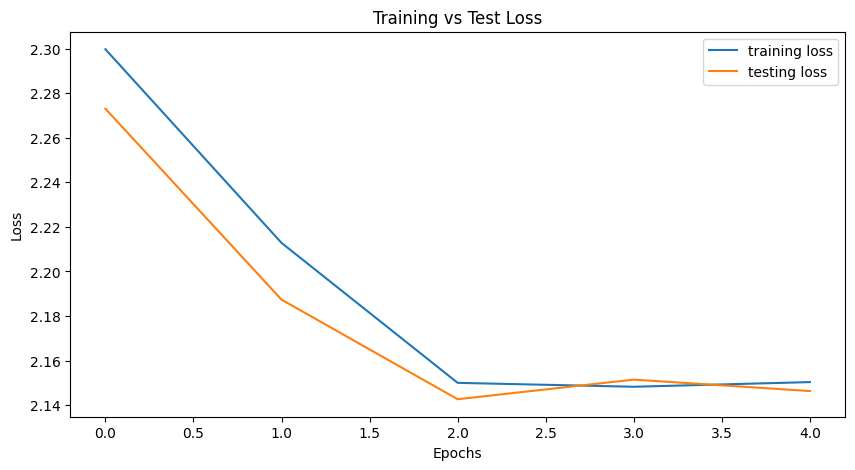

In [30]:
plt.figure(figsize=(10,5))
plt.plot(training_losses,label='training loss')
plt.plot(val_losing,label='testing loss')
plt.title("Training vs Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


Text(0, 0.5, 'Accuracy')

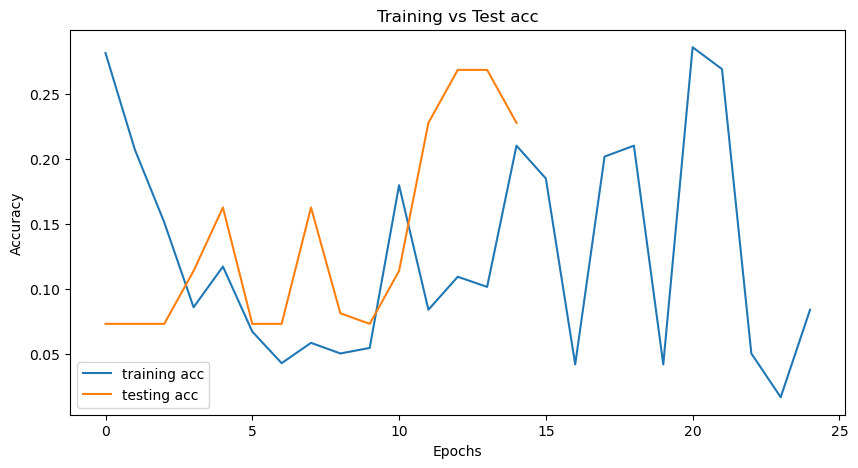

In [63]:
plt.figure(figsize=(10,5))
plt.plot(training_accs,label='training acc')
plt.plot(val_accuracy,label='testing acc')
plt.title("Training vs Test acc")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [43]:
#save the model
checkpoint = {
    'epoch': epochs+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
   
}
# Specify the path to save the model to:
save_path = "/home/jbg/Documents/geofisica_lapaz/"

torch.save(checkpoint,save_path)

RuntimeError: [enforce fail at inline_container.cc:642] . invalid file name: /home/jbg/Documents/geofisica_lapaz/